## Who's a good boy?

Trick question, you turkey. All dogs are good boys. At least, I like to think so. 

The following code will build a CNN which will predict the breed of any given pooch. After that, it's up to you as to who is the best dog. 


![alt text][logo]
[logo]: http://i0.kym-cdn.com/photos/images/original/001/251/488/5bf.jpg "Logo Title Text 2"


In [1]:
import os 
os.getcwd()

'/Users/jglazier/Downloads'

In [2]:
from os import listdir
from PIL import Image as PImage

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/Users/jglazier/Downloads/train/0a0c223352985ec154fd604d7ddceabd.jpg')
imgplot = plt.imshow(img)
plt.show()

## ~wow~

In [2]:
from os import listdir
from PIL import Image as PImage

#Let's now create a function which will read in all of our images in a directory. 

#It should be noted, that there are often issues with certain packages being unable to load all of the images at once
#To account for this, we have done two things. The first of which is to copy and then delete images within the fucntion
#The second is we specify a length of array for which we can search along.


def loadImages(path, start, end):
    '''Inputs: 
        path - where the files are stored on the computer
        start- the start of the index of the folder in which we will search 
        end - where to stop our search 
        
        Outputs: 
         loadedImages - all of the images we want to load :)
    
    '''

    imagesList = listdir(path)
    imagesList = imagesList[start: end]
    
    loadedImages = []
    for image in imagesList:
        img = PImage.open(path + image)
        keep = img.copy()
        loadedImages.append(keep)
        #img.close()

    return loadedImages

path = '/Users/jglazier/Downloads/train/'
trainsize = len(listdir(path))


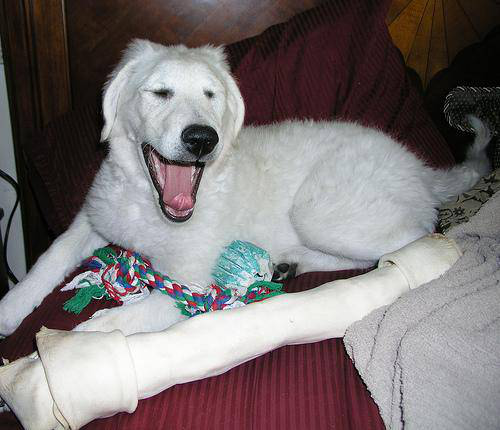

In [3]:

# your images in an array
imgs = loadImages(path,0, trainsize-1)
imgs[0]

~so tired~

In [4]:
#import libraries`

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import cv2
from keras.preprocessing import image
from tqdm import tqdm
import tensorflow as tf
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [5]:
x = image.img_to_array(imgs[0])  # this is a Numpy array with shape (3, img_height, im_widtb)
x = x.reshape((1,) + x.shape)

In [6]:
x.shape

(1, 430, 500, 3)

In [7]:
df_train = pd.read_csv('/Users/jglazier/Downloads/labels.csv')

In [8]:
targets_series = pd.Series(df_train['breed'])

In [9]:
#Let's one hot the labels such that we can chose between 120 breeds
one_hot = pd.get_dummies(targets_series, sparse = True)

In [10]:
one_hot_labels = np.asarray(one_hot)
one_hot_labels.shape

(10222, 120)

In [11]:
#Make the image size 64 so that we can have a reasonable calculation time

im_size = 64
x_train = []
y_train = []
x_test = []

In [12]:
df = pd.read_csv('/Users/jglazier/Downloads/labels.csv')
n = len(df)
breed = set(df['breed'])

In [13]:
#Make train and test sets

i = 0 
for f, breed in tqdm(df_train.values):
    img = cv2.imread('/Users/jglazier/Downloads/train/{}.jpg'.format(f))
    label = one_hot_labels[i]
    x_train.append(cv2.resize(img, (im_size, im_size)))
    y_train.append(label)
    i += 1

100%|██████████| 10222/10222 [01:02<00:00, 164.06it/s]


In [14]:
df_test = pd.read_csv('/Users/jglazier/Downloads/sample_submission.csv')

In [15]:
for f in tqdm(df_test['id'].values):
    img = cv2.imread('/Users/jglazier/Downloads/test/{}.jpg'.format(f))
    x_test.append(cv2.resize(img, (im_size, im_size)))

100%|██████████| 10357/10357 [01:13<00:00, 141.36it/s]


In [16]:
#Put into array and normalize

y_train_raw = np.array(y_train, np.uint8)
x_train_raw = np.array(x_train, np.float32) / 255.
x_test  = np.array(x_test, np.float32) / 255.

In [17]:
x_train_raw.shape

(10222, 64, 64, 3)

In [18]:
num_class = y_train_raw.shape[1] 
num_class

120

In [19]:
from sklearn.cross_validation import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(x_train_raw, y_train_raw, test_size=0.3, random_state=1)

/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [20]:
im_size_flat = im_size * im_size
im_shape = (im_size, im_size)

In [21]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    
   
    X_pad = np.pad(X, ((0,0), (pad, pad), (pad,pad), (0,0),), 'constant')
   
    
    return X_pad

In [22]:
X_train = zero_pad(X_train, 5)

In [23]:
def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, result of convolving the sliding window (W, b) on a slice x of the input data
    """

   
    # Element-wise product between a_slice and W
    s = np.multiply(a_slice_prev, W)
    # Sum over all entries of the volume s.
    Z = np.sum(s)
    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    Z = Z + float(b)
   

    return Z

In [24]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    
    # Retrieve dimensions from A_prev's shape 
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape (
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters" 
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Compute the dimensions of the CONV output volume using the formula given above
    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1
    
    # Initialize the output volume Z with zeros
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):                               # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i]                               # Select ith training example's padded activation
        for h in range(n_H):                           # loop over vertical axis of the output volume
            for w in range(n_W):                       # loop over horizontal axis of the output volume
                for c in range(n_C):                   # loop over channels (= #filters) of the output volume
                    
                    # Find the corners of the current "slice" 
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell)
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end , : ]
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[...,c], b[...,c])
                                        
    
    
    # Making sure your output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [25]:
def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
 
    for i in range(m):                         # loop over the training examples
        for h in range(n_H):                     # loop on the vertical axis of the output volume
            for w in range(n_W):                 # loop on the horizontal axis of the output volume
                for c in range (n_C):            # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice" 
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                                       
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)

    
    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    # Making sure your output shape is correct
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [26]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    
    X = tf.placeholder(tf.float32, shape = [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, shape = [None, n_y])
    
    
    return X, Y

In [27]:
X, Y = create_placeholders(64, 64, 3, 120)

In [28]:
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 120), dtype=float32)


In [29]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
   
    W1 = tf.get_variable("W1", [4,4,3,8], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [2,2,8,16], initializer = tf.contrib.layers.xavier_initializer(seed=0))
   

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [30]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

W1 = [ 0.00131723  0.14176141 -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


In [31]:

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 120 neurons in output layer
    Z3 = tf.contrib.layers.fully_connected(P2, 120, activation_fn=None)
    

    return Z3

In [32]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 120)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,120)})
    print("Z3 = " + str(a))

Z3 = [[  1.36476588e+00  -1.42153978e+00   1.41368055e+00  -2.62180400e+00
    8.79012346e-01  -1.06889129e+00   1.93306580e-01  -7.65349045e-02
    4.53122050e-01  -1.06270313e+00   2.75037289e-02   6.19432807e-01
    1.27945638e+00  -2.03372896e-01   4.60051060e-01   1.31895137e+00
   -2.27704382e+00  -6.11494839e-01  -2.04322743e+00   2.18857229e-01
    1.06669629e+00  -2.15424848e+00  -8.37037206e-01  -7.48645961e-01
   -4.87406135e-01  -5.06039202e-01  -5.12581646e-01  -1.13886178e+00
   -7.45316923e-01  -9.96867895e-01  -1.31503165e+00   3.16159070e-01
    3.53076458e-01   2.18441576e-01   2.10809827e+00  -1.75810921e+00
    1.75501144e+00  -9.13577437e-01   1.68168589e-01   1.36079907e+00
    1.22717762e+00   5.87000847e-01   8.58432770e-01  -3.88622552e-01
    3.22127402e-01   7.81904399e-01   3.93873483e-01   3.35869730e-01
    1.03239775e+00  -1.83334386e+00   1.62096786e+00   3.56868327e-01
    7.82051802e-01  -1.60373628e-01  -5.54871440e-01  -2.23632526e+00
    7.44696319e

In [33]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    
    cost = tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y)
    cost = tf.reduce_mean(cost)
   
    
    return cost

In [34]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 120)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,64,64,3), Y: np.random.randn(4,120)})
    print("cost = " + str(a))

cost = 8.96691


In [35]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 50, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
 

    # Initialize parameters
 
    parameters = initialize_parameters()
    
    
    # Forward propagation
    Z3 = forward_propagation(X, parameters)
    
    
    # Cost function
    cost = compute_cost(Z3, Y)
    

    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
 
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
               
                _ , temp_cost = sess.run([optimizer, cost], feed_dict ={X: minibatch_X, Y: minibatch_Y})
              
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

In [36]:


def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :, :, :]
    shuffled_Y = Y[permutation, :]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
     
        mini_batch_X = shuffled_X[k * mini_batch_size:(k + 1) * mini_batch_size, :, :, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size:(k + 1) * mini_batch_size, :]
       
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        
        end = m - mini_batch_size * int(m / mini_batch_size)
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size:, :, :, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size:, :]
      
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

#### Tensorflow vs Keras

As you can see above, we have implemented a model from scratch in tensorflow. It can be intricately tuned, but we will see from the below performance that we have missed the mark and would likely need ot reassess exactly the structure we want in our network. 

Keras on the other hand is easy to rapidly interate networks and it is observed that this network performs much, much better. 

Cost after epoch 0: 4.831939
Cost after epoch 5: 4.533658
Cost after epoch 10: 4.175654
Cost after epoch 15: 3.882956
Cost after epoch 20: 3.698969
Cost after epoch 25: 3.571371
Cost after epoch 30: 3.468659
Cost after epoch 35: 3.404009
Cost after epoch 40: 3.345291
Cost after epoch 45: 3.301264


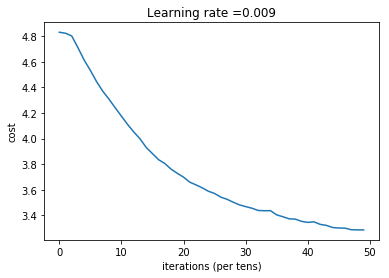

Tensor("Mean_1:0", shape=(), dtype=float32)


ValueError: Cannot feed value of shape (3067, 64, 64, 3) for Tensor u'Placeholder:0', which has shape '(?, 74, 74, 3)'

In [37]:
from tensorflow.python.framework import ops


_, _, parameters = model(X_train, Y_train, X_test, Y_test)

In [38]:
import keras
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.vgg16 import VGG16


base_model = VGG16(weights= None , include_top=False)

input = Input(shape=(64, 64, 3),name = 'image_input')

# Add a new top layer


output_vgg16_conv = base_model(input)
x = Flatten()(output_vgg16_conv)
predictions = Dense(120, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=input, outputs=predictions)

# First: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 64, 64, 3)         0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               245880    
Total params: 14,960,568
Trainable params: 245,880
Non-trainable params: 14,714,688
_________________________________________________________________


In [39]:
from tensorflow.contrib.keras.python.keras.backend import clear_session
clear_session()

model.fit(X_train, Y_train, epochs=1, verbose = 1)


ValueError: Error when checking input: expected image_input to have shape (64, 64, 3) but got array with shape (74, 74, 3)

In [40]:
preds = happyModel.evaluate(X_test, Y_test, batch_size=32, verbose=1, sample_weight=None)

print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

NameError: name 'happyModel' is not defined

## Testing Time

Let's see if my model can recognize my dog. She is a yellow lab. 



In [41]:
from keras.applications.imagenet_utils import preprocess_input

pep_path = '/Users/jglazier/Downloads/pepper.jpg'

img = image.load_img(pep_path, target_size=(64, 64))
imshow(img)

pep = image.img_to_array(img)
pep = np.expand_dims(pep, axis=0)
pep = preprocess_input(pep)

print(happyModel.predict(pep))

NameError: name 'happyModel' is not defined

In [42]:
from keras.models import Sequential


optimizer = Nadam(lr=0.002,
                  beta_1=0.9,
                  beta_2=0.999,
                  epsilon=1e-08,
                  schedule_decay=0.004)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['categorical_accuracy'])

NameError: name 'Nadam' is not defined